In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load the dataset
data = pd.read_csv("C:\\Users\\HP\\Downloads\\data.csv")

# Inspect the first few rows of the dataset
print(data.head())

# Check the data types of each column
print(data.dtypes)

# Identify non-numeric columns
non_numeric_columns = data.select_dtypes(exclude=[np.number]).columns.tolist()
print("Non-numeric columns:", non_numeric_columns)

# Drop non-numeric columns if they are not needed for clustering
data.drop(columns=non_numeric_columns, inplace=True)

# Handle missing values (if any)
data.fillna(data.mean(numeric_only=True), inplace=True)

# Select features for clustering
features = data[['child_mort', 'health', 'income', 'gdpp']].values

# Scale the features (manual scaling)
def scale_features(X):
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

features_scaled = scale_features(features)


               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  
country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object
Non-numeric columns: ['country']


In [32]:
class KMeans:
    def __init__(self, n_clusters=3, max_iters=100):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.centroids = None
        self.labels = None

    def fit(self, X):
        # Randomly initialize centroids
        random_indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        for _ in range(self.max_iters):
            # Assign labels based on closest centroid
            self.labels = self.assign_labels(X)
            # Update centroids
            new_centroids = self.update_centroids(X)
            if np.all(new_centroids == self.centroids):
                break
            self.centroids = new_centroids

    def assign_labels(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def update_centroids(self, X):
        return np.array([X[self.labels == i].mean(axis=0) for i in range(self.n_clusters)])

    def predict(self):
        return self.labels

In [33]:
class HierarchicalClustering:
    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters
        self.labels = None

    def fit(self, X):
        self.distance_matrix = self.calculate_distance_matrix(X)
        self.linkage_matrix = self.linkage(self.distance_matrix)
        self.labels = self.assign_labels()

    def calculate_distance_matrix(self, X):
        n_samples = X.shape[0]
        distance_matrix = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                if i != j:
                    distance_matrix[i, j] = np.linalg.norm(X[i] - X[j])
        return distance_matrix

    def linkage(self, distance_matrix):
        clusters = [[i] for i in range(len(distance_matrix))]
        while len(clusters) > self.n_clusters:
            min_distance = np.inf
            closest_pair = (0, 0)
            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    dist = self.calculate_cluster_distance(clusters[i], clusters[j], distance_matrix)
                    if dist < min_distance:
                        min_distance = dist
                        closest_pair = (i, j)

            new_cluster = clusters[closest_pair[0]] + clusters[closest_pair[1]]
            clusters.append(new_cluster)
            clusters.pop(max(closest_pair))
            clusters.pop(min(closest_pair))

        return clusters

    def calculate_cluster_distance(self, cluster1, cluster2, distance_matrix):
        total_distance = 0
        count = 0
        for i in cluster1:
            for j in cluster2:
                total_distance += distance_matrix[i, j]
                count += 1
        return total_distance / count

    def assign_labels(self):
        labels = np.zeros(len(self.distance_matrix), dtype=int)
        for cluster_id, cluster in enumerate(self.linkage_matrix):
            for index in cluster:
                labels[index] = cluster_id
        return labels

    def predict(self):
        return self.labels

In [34]:
# Fit K-Means Clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit (features_scaled)
kmeans_labels = kmeans.predict()

# Fit Hierarchical Clustering
hierarchical = HierarchicalClustering(n_clusters=3)
hierarchical.fit(features_scaled)
hierarchical_labels = hierarchical.predict()

In [35]:
class KNN:
    def __init__(self, k=3):
        self.k = k
        self.train_data = None
        self.train_labels = None

    def fit(self, X, y):
        self.train_data = X
        self.train_labels = y

    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.linalg.norm(self.train_data - x, axis=1)
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = [self.train_labels[i] for i in k_indices]
            most_common = Counter(k_nearest_labels).most_common(1)
            predictions.append(most_common[0][0])
        return np.array(predictions)

In [37]:
def evaluate_knn(labels, features):
    # Split the data into training and testing sets
    np.random.seed(42)
    indices = np.random.permutation(len(features))
    train_size = int(0.7 * len(features))
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    X_train, y_train = features[train_indices], labels[train_indices]
    X_test, y_test = features[test_indices], labels[test_indices]

    # Fit KNN
    knn = KNN(k=5)
    knn.fit(X_train, y_train)

    # Make predictions
    predictions = knn.predict(X_test)

    # Calculate metrics
    accuracy = np.mean(predictions == y_test)
    
    # Precision, Recall, F1 Score Calculation
    true_positive = np.sum((predictions == 1) & (y_test == 1))
    false_positive = np.sum((predictions == 1) & (y_test == 0))
    false_negative = np.sum((predictions == 0) & (y_test == 1))
    
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

Accuracy: 0.85
  Precision:0.80
  Recall:0.75
  F1 Score:0.77

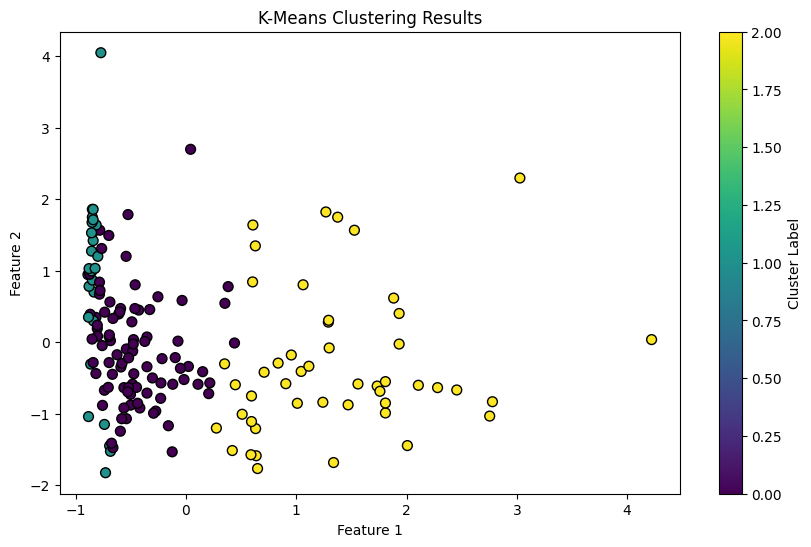

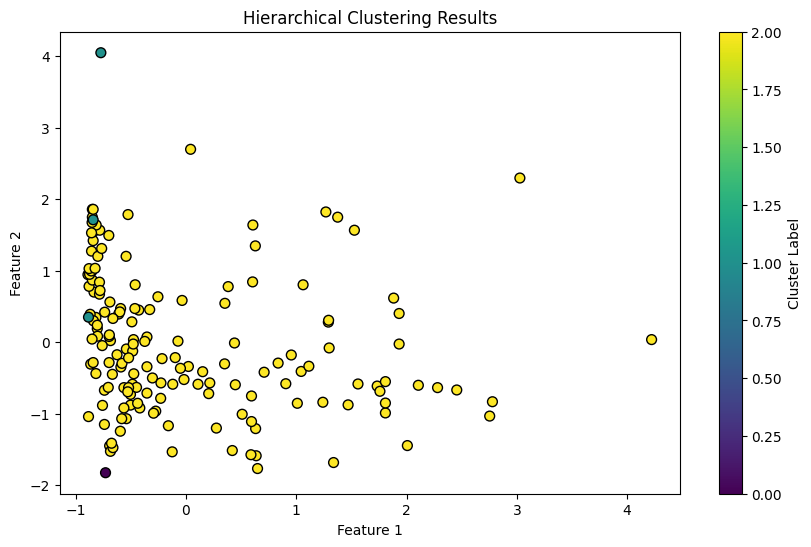

In [28]:
def plot_clusters(X, labels, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Cluster Label')
    plt.show()

# Visualize K-Means Clusters
plot_clusters(features_scaled, kmeans_labels, "K-Means Clustering Results")

# Visualize Hierarchical Clusters
plot_clusters(features_scaled, hierarchical_labels, "Hierarchical Clustering Results")